<a href="https://colab.research.google.com/github/Monserrat321/Monserrat321/blob/main/Biologia%20matematica%20I/II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Clasificación multiclase de imágenes**

Usaremos el conjunto de datos proporcionado por *Kaggle*, [*Skin cancer classification*](https://www.kaggle.com/pattnaiksatyajit/skin-cancer)
.

**Objetivo** Entrenar una red neuronal convolucional capáz de distinguir entre distintas clasificaciones de tumores en la piel.

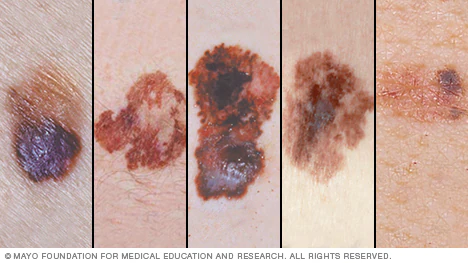

In [ ]:
import torch 
import time
import matplotlib 
import numpy as np
from tqdm import tqdm
from torch import nn, optim
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
matplotlib.style.use('ggplot')

## Revisar disponibilidad GPU

In [ ]:
#Debido a los limites de uso de colab, no me fue posible acceder ya a GPU, asi que trabaje con CPU.
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

print(device)

cpu


## Carga de datos

Los archivos se encuentran en una carpeta .zip llamada "archive", esta carpeta esta en google drive.

In [ ]:
import os
import zipfile
import random
from shutil import copyfile

In [ ]:
local_zip = '/content/drive/MyDrive/archive.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
print('Archivos en la carpeta Train: {}'.format(len(os.listdir('/tmp/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'))))
print('Archivos en la carpeta Test: {}'.format(len(os.listdir('/tmp/Skin cancer ISIC The International Skin Imaging Collaboration/Test/'))))

Archivos en la carpeta Train: 9
Archivos en la carpeta Test: 9


La carpeta "archive.zip" tiene 2 carpetas, "Train" y "Test", estas a su vez, tienen 9 subcarpetas cada una, cada subcarpeta son imagenes correspondientes a un tipo de tumor. Teniendo entonces 9 clases diferentes de tumor.

Estas clases son:


1.   Vascular lesion.
2.   Squamous cell carcinoma.
3. Nevus.
4. Actinic keratosis.
5. Pigmented benign keratosis.
6. Basal cell carcinoma.
7. Dermatofibroma.
8. Seborrheic keratosis.
9. Melanoma.



In [ ]:
data_dir='/tmp/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
test_dir='/tmp/Skin cancer ISIC The International Skin Imaging Collaboration/Test/'
classes = os.listdir(data_dir)

print(classes)

['melanoma', 'dermatofibroma', 'squamous cell carcinoma', 'pigmented benign keratosis', 'vascular lesion', 'basal cell carcinoma', 'nevus', 'seborrheic keratosis', 'actinic keratosis']


## Definición del conjunto de datos.

Utilizaremos las clase  `ImageFolder` del módulo `torchvison.datasets` que agrupa los elementos del conjunto de datos a una estructura iterable.
En nuestro caso, tenemos la siguiente estructura:
```
tmp
 +- Skin cancer ISIC The International Skin Imaging Collaboration
    |
    +- Train
    |
    |  +- vascular lesion
    |  +- squamous cell carcinoma
    |  +-nevus
    |  +-actinic keratosis
    |  +-pigmented benign keratosis
    |  +-basal cell carcinoma
    |  +-dermatofibroma
    |  +-seborrheic keratosis
    |  +-melanoma
    |
    +- Test
    |
    |  +- vascular lesion
    |  +- squamous cell carcinoma
    |  +-nevus
    |  +-actinic keratosis
    |  +-pigmented benign keratosis
    |  +-basal cell carcinoma
    |  +-dermatofibroma
    |  +-seborrheic keratosis
    |  +-melanoma
    |
```
 `ImageFolder` le asignará a cada imagen contenida en dichas subcarpetas la etiqueta 0,1,2,3,4,5,6,7,8, respectivamente.

 También, por medio de  `transforms` ajustaremos las imagenes, en nuestro caso le daremos 5 grados de libertad para rotar, ajustaremos las imagenes a un tamaño de $100 × 100$ pixeles, covertiremos las imagenes a tensores y finalmente cada entrada la normalizaremos.

In [ ]:
from torchvision import datasets, transforms, models 

In [ ]:
train_transform=transforms.Compose([  #Nos permite componer varias transformaciones
       # transforms.RandomRotation(5),      # rota +/- 5 grados
        transforms.Resize((100,100)),             # Cambiamos los pixeles 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [ ]:
from torchvision.datasets import ImageFolder

In [ ]:
dataset = ImageFolder(data_dir, transform=train_transform)
print('Tamaño del dataset de entrenamiento :', len(dataset))
testset = ImageFolder(test_dir, transform=train_transform)
print('Tamaño del dataset de prueba :', len(testset))

Tamaño del dataset de entrenamiento : 2239
Tamaño del dataset de prueba : 118


Verificamos la discretización de las clases.

In [ ]:
print(dataset.class_to_idx)
print(dataset.classes)

{'actinic keratosis': 0, 'basal cell carcinoma': 1, 'dermatofibroma': 2, 'melanoma': 3, 'nevus': 4, 'pigmented benign keratosis': 5, 'seborrheic keratosis': 6, 'squamous cell carcinoma': 7, 'vascular lesion': 8}
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# Visualización de datos.

In [ ]:
#Solo los datos de la imagen 
img, label = dataset[100]
print(label)
print(img.shape)

0
torch.Size([3, 100, 100])


In [ ]:
# Funcion para mostrar la imagen
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  actinic keratosis (0)


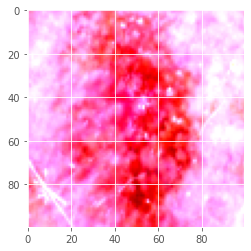

In [ ]:
show_image(*dataset[17])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  basal cell carcinoma (1)


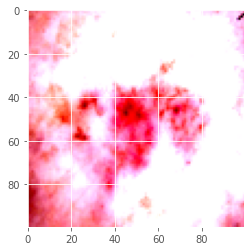

In [ ]:
show_image(*dataset[300])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  nevus (4)


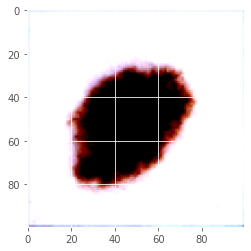

In [ ]:
show_image(*dataset[1030])



---



#Dataset

Ahora dividiremos el `testset` en 2 partes, para tener imagenes que podamos utilizar de validación en el entrenamiento.

In [ ]:
#####Revisar

val_size = 0.4 # parte para validar
n = len(testset)
indices = list(range(n))
np.random.shuffle(indices) # revolvemos los indices
split = int(np.floor(val_size * n)) 
train_idx, val_idx = indices[split:], indices[:split] # seprarmos los indices

test_set = torch.utils.data.Subset(testset, train_idx) # tomamos un subconjunto de acuerdo a los indices
val_set = torch.utils.data.Subset(testset, val_idx)
n_test = len(test_set)
n_val = len(val_set) 

In [ ]:
#len(trainset), len(val_set), len(testset)   
print(n_test,n_val,len(testset))


71 47 118


In [ ]:
#definicion del data loader
train_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=128, shuffle=True)

val_loader = torch.utils.data.DataLoader(val_set,
                                          batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=n_test, shuffle=False)

## Definición de la arquitectura de la red.


 Sea $f_a(\cdot |\theta): \mathbb{R}^{k \times 3\times 100 \times 100}\rightarrow \mathbb{R}^{k \times 9}$ con $$a=\left(\langle \text{Conv}(1, 6, k=5, p=2), \text{Sigmoid}, \text{AvgPool}(k=2, s=2), \text{Conv}(6, 16, k=5), \text{Sigmoid}, \text{AvgPool}(k=2, s=2)\rangle\cup\langle [30000, 512, 512, 9], \{\text{ReLU, ReLU, Linear}\}\rangle\right)$$
la red neuronal que usaremos para la tarea de clasificación. 


El modelo completo esta dado por la siguiente expresión: 
$$\text{Softmax}\circ f(\cdot|\theta): \mathbb{R}^{k \times 3 \times 100 \times 100} \rightarrow [0, 1]^{9}.$$

In [ ]:
from collections import OrderedDict

c = 3 # canales de la imagen
n_class = 9 # define the architecture of LeNet
classifier = nn.Sequential(OrderedDict([
    ('z1', nn.Conv2d(c, 6, kernel_size=5, padding=2)),
    ('h1', nn.Sigmoid()),
    ('p1', nn.AvgPool2d(kernel_size=2, stride=2)),
    ('z2', nn.Conv2d(6, 16, kernel_size=5)),
    ('h2', nn.Sigmoid()),
    ('p2', nn.AvgPool2d(kernel_size=2, stride=2)), # Aquí termina la parte convolucional
    ('f2', nn.Flatten()),
    ('z3', nn.Linear(2116* 2 * 2, 120)), # Ya completamente conectada
    ('h3', nn.Sigmoid()),
    ('z4', nn.Linear(120, 84)),
    ('h4', nn.Sigmoid()),
    ('z5', nn.Linear(84, 9)),
  ]))

In [ ]:
x = torch.rand(size=(3, 3, 100, 100), dtype=torch.float32)
for layer in classifier:
  x = layer(x)
  print(layer.__class__.__name__, 'output shape: \t', x.shape)

Conv2d output shape: 	 torch.Size([3, 6, 100, 100])
Sigmoid output shape: 	 torch.Size([3, 6, 100, 100])
AvgPool2d output shape: 	 torch.Size([3, 6, 50, 50])
Conv2d output shape: 	 torch.Size([3, 16, 46, 46])
Sigmoid output shape: 	 torch.Size([3, 16, 46, 46])
AvgPool2d output shape: 	 torch.Size([3, 16, 23, 23])
Flatten output shape: 	 torch.Size([3, 8464])
Linear output shape: 	 torch.Size([3, 120])
Sigmoid output shape: 	 torch.Size([3, 120])
Linear output shape: 	 torch.Size([3, 84])
Sigmoid output shape: 	 torch.Size([3, 84])
Linear output shape: 	 torch.Size([3, 9])


Es necesario guardar a los tensores que estemos utilizando en el gpu. Esta acción la efectuamos al usar el método `.to(device)` en cada tensor que usemos.

In [ ]:
print('x= ', x)
x_gpu = x.to(device)
print('x_gpu= ',x_gpu)

x=  tensor([[-0.4871, -0.5847, -0.0611,  0.0541,  0.1708,  0.4277, -0.1065,  0.0299,
         -0.1591],
        [-0.4871, -0.5847, -0.0611,  0.0541,  0.1708,  0.4277, -0.1065,  0.0300,
         -0.1591],
        [-0.4871, -0.5847, -0.0611,  0.0541,  0.1708,  0.4278, -0.1065,  0.0300,
         -0.1592]], grad_fn=<AddmmBackward0>)
x_gpu=  tensor([[-0.4871, -0.5847, -0.0611,  0.0541,  0.1708,  0.4277, -0.1065,  0.0299,
         -0.1591],
        [-0.4871, -0.5847, -0.0611,  0.0541,  0.1708,  0.4277, -0.1065,  0.0300,
         -0.1591],
        [-0.4871, -0.5847, -0.0611,  0.0541,  0.1708,  0.4278, -0.1065,  0.0300,
         -0.1592]], device='cuda:0', grad_fn=<ToCopyBackward0>)


En particular deberemos de transformar cada uno de los elementos de los conjuntos de datos y todos los parámetros de la red neuronal. La primera transformación la podemos efectuar dentro del entrenamiento y el segundo lo haremos en la siguiente instrucción.

In [ ]:
classifier = classifier.to(device)

## Función objetivo y optimizador
* Función objetivo: [Categorical Cross Entropy Loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
* Optimizador: [RMSPROP](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html).

In [ ]:
criterion = nn.CrossEntropyLoss()
params = classifier.parameters()
optimizer = torch.optim.RMSprop(params, lr=0.001, alpha=0.9, eps=1e-07, weight_decay=0, momentum=0, centered=False)

Entrenamiento

In [ ]:
#Entrenamiento por epoca
import torch.nn.functional as F

def fit(model, dataloader, optimizer, criterion, pbar, train=True):
  running_loss = 0.0
  correct = 0
  total = 0
  for i, data in enumerate(dataloader, 0):
    X, Y = data
    X = X.to(device) # Por si hay gpu
    Y = Y.to(device) # Por si hay gpu
    if train:
      optimizer.zero_grad() # reinicia el gradiente
    pred = model(X) # forward pass 
    loss = criterion(pred, Y) # evaluación de predicción
    if train:
      loss.backward() # cálcula las derivadas 
      optimizer.step() # paso de optimización 

    running_loss += loss.item()
    avg_loss = running_loss/(i + 1)
    probs = F.softmax(pred, 1)
    label = torch.argmax(probs, dim=1)
    correct += torch.sum(label == Y).item()
    total += Y.shape[0]
    acc = correct/total
        
    pbar.set_postfix(avg_loss='{:.4f}'.format(avg_loss), acc='{:.4f}'.format(acc))
    pbar.update(Y.shape[0])
  return avg_loss, acc

In [ ]:
#Ciclo de entrenamiento
def train(model, train_loader, val_loader, optimizer, criterion, epochs=20):
  train_time = 0
  epoch_loss = list(); epoch_acc = list()
  val_loss = list(); val_acc = list()

  n_train = len(train_loader.dataset)
  n_val = len(val_loader.dataset)
  model.train() # -> aplica drop si lo tiene el modelo y lleva registro de los gradientes
  for epoch in range(epochs):
    start_time = time.time()
    with tqdm(total=n_train, position=0) as pbar_train:
      pbar_train.set_description(f'Epoch {epoch + 1}/'+str(epochs)+' - train')
      pbar_train.set_postfix(avg_loss='0.0', acc='0.0')
      loss_train, acc_train = fit(model, train_loader, optimizer, criterion, pbar_train)
      train_time +=  time.time() - start_time
    model.eval() # -> de esta forma no incluye dropout, ni lleva registro de los gradientes
    with tqdm(total=n_val, position=0) as pbar_val:
      pbar_val.set_description(f'Epoch {epoch + 1}/'+str(epochs)+' - val')
      pbar_val.set_postfix(avg_loss='0.0', acc='0.0')
      loss_val, acc_val = fit(model, val_loader, optimizer, criterion, pbar_val, train=False)

    epoch_loss.append(loss_train)
    epoch_acc.append(acc_train)

    val_loss.append(loss_val)
    val_acc.append(acc_val)

  return epoch_loss, epoch_acc, val_loss, val_acc, train_time

In [ ]:
epoch_loss, epoch_acc, val_loss, val_acc, train_time = train(classifier, train_loader, val_loader, optimizer, criterion)
print("\n --- %s seconds ---", train_time)

Epoch 20/20 - val: 100%|██████████| 47/47 [00:02<00:00, 17.28it/s, acc=0.2340, avg_loss=2.1194]


 --- %s seconds --- 768.0083208084106


# Evaluacion del entrenamiento.

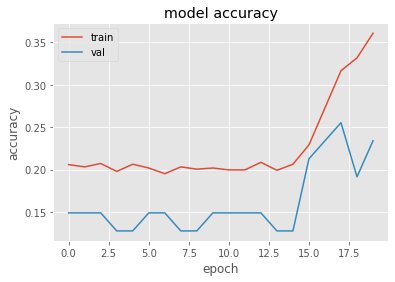

In [ ]:
plt.plot(epoch_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

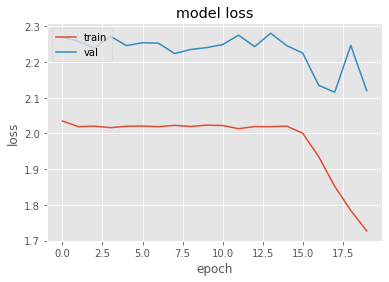

In [ ]:
plt.plot(epoch_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def test(model, test_loader):
  total = len(test_loader.dataset)
  X, Y = next(iter(test_loader))
  X = X.to(device)
  Y = Y.to(device)
  pred = model(X) # forward pass 
  loss = criterion(pred, Y) # evaluación de predicción
  probs = F.softmax(pred, 1)
  label = torch.argmax(probs, dim=1)
  correct = torch.sum(label == Y).item()
  acc = correct/total
  return loss.item(), acc

In [ ]:
loss, acc = test(classifier, test_loader)
print('modelo simple: loss ={}, acc= {}'.format(loss, acc))

modelo simple: loss =2.1114206314086914, acc= 0.2676056338028169


Podemos observar que la exactitud es muy baja, por lo que ahora utilizaremos una red preentrenada.

# Transfer Learning.

Muchos algoritmos usados para reconocimiento de imágenes suelen ocupar modelos ya entrenados en la popular base de datos ImageNet. Con esta base de datos, se tiene como reto el clasificar imágenes de mil clases distintas. Y para esto la red **VGG-16** ya esta entrenada.

Para hacer el transfer learning, utilizaremos la red VGG y solo se realizaran 
cambios en la parte de la red completamente conectada.

In [ ]:
import torchvision.models as models

vgg = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

La red VGG es una red neuronal de convolución que se puede pensar como una red con tres partes relevantes:

1. features (aquí están las capas convolucionales).
2. avgpool
 3. classifier(aquí esta la red completamente conectada).


Y es en classifier en donde haremos los cambios para que se adapten a nuestra base de datos.

El modelo VGG16 fue utilizado para clasificar imágenes en 1000 categorías, pero no fue entrenando
para distinguir tumores en la piel, es por ello que es necesario redefinir la última capa y pasar de
1000 salidas a 9.

In [ ]:
vgg.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 512),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(512, 16),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(16, 9),
    nn.Sigmoid()
)

Congelamiento de capas convolucionales.

In [ ]:
for param in vgg.classifier.parameters(): param.requires_grad = False

if torch.cuda.is_available():
  vgg = vgg.cuda()

In [ ]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
x,y=test_set[0]
x=x.reshape((1,3,100,100))
vgg(x)

tensor([[0.4899, 0.5539, 0.5576, 0.5731, 0.5562, 0.5207, 0.5204, 0.4365, 0.5170]],
       grad_fn=<SigmoidBackward0>)

En este caso sólo le pasaremos al optimizador los parámetros de classifier.

In [ ]:
optimizer = optim.SGD(vgg.classifier.parameters(),lr=0.0001,momentum=0.5)

Entrenamiento


In [ ]:
epochs = 5
epoch_loss, epoch_acc, val_loss, val_acc, train_time = train(vgg, train_loader, val_loader, optimizer, criterion, epochs)
print("\n --- %s seconds ---", train_time)

Epoch 5/5 - val: 100%|██████████| 47/47 [00:02<00:00, 16.41it/s, acc=0.1064, avg_loss=2.2036]


 --- %s seconds --- 235.28700160980225


In [ ]:
def show_acc_loss(epoch_acc, val_acc, epoch_loss, val_loss):
  fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 6))
  ax1.plot(epoch_acc, label='train')
  ax1.plot(val_acc, label='val')
  ax1.set_title('model accuracy')
  ax1.set_ylabel('accuracy')
  ax1.set_xlabel('epoch')
  ax1.legend()

  ax2.plot(epoch_loss, label='train')
  ax2.plot(val_loss, label='val')
  ax2.set_title('model loss')
  ax2.set_ylabel('loss')
  ax2.set_xlabel('epoch')
  ax2.legend()
  plt.show()

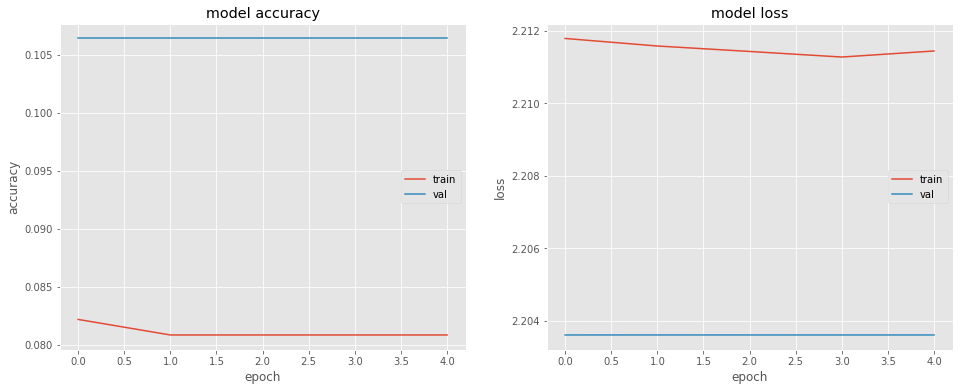

In [ ]:
show_acc_loss(epoch_acc, val_acc, epoch_loss, val_loss)

In [ ]:
for layer in vgg.classifier.children():
    if(type(layer) == nn.Dropout):
        layer.p = 0.2

In [ ]:
epochs = 10
epoch_loss, epoch_acc, val_loss, val_acc, train_time = train(vgg, train_loader, val_loader, optimizer, criterion, epochs)
print("\n --- %s seconds ---", train_time)

Epoch 10/10 - val: 100%|██████████| 47/47 [00:02<00:00, 16.64it/s, acc=0.1064, avg_loss=2.2036]


 --- %s seconds --- 466.9754550457001


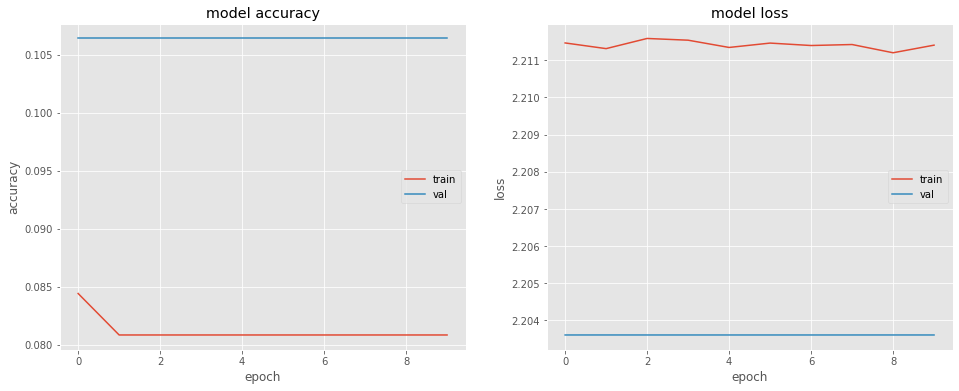

In [ ]:
show_acc_loss(epoch_acc, val_acc, epoch_loss, val_loss)

# Data Augmentation 

En muchos casos no se tiene la cantidad suficiente de imágenes como para realizar un entrena-
miento efectivo. Una forma de solventar ese problema es utilizando nuevos datos falsos. La técnica
de data augmentation consiste prácticamente en incrementar de forma artificial el número de imá-
genes del conjunto de datos. Aunque en nuestro caso, estas imágenes no son imágenes totalmente
nuevas sino una variación de las imágenes originales.

Para esto, realizaremos una transformación. En donde cambiaremos los pixeles a $150×150$, se realizara un "efecto espejo" de forma aleatoria y se agregara una rotación con 5 grados de libertad.


In [ ]:
train_transforms = transforms.Compose([transforms.Resize((150,150))
                                       ,transforms.RandomHorizontalFlip()
                                       ,transforms.RandomRotation(5)
                                       ,transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])
train_set = ImageFolder('/tmp/Skin cancer ISIC The International Skin Imaging Collaboration/Train/', transform=train_transforms)
val_set = ImageFolder('/tmp/Skin cancer ISIC The International Skin Imaging Collaboration/Test/', transform=train_transform)

In [ ]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  nevus (4)


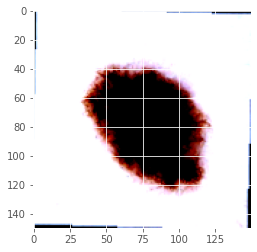

In [ ]:
show_image(*train_set[1030])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  nevus (4)


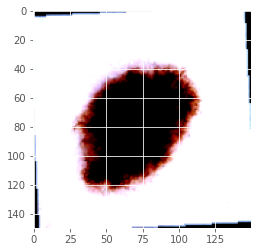

In [ ]:
show_image(*train_set[1030])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  nevus (4)


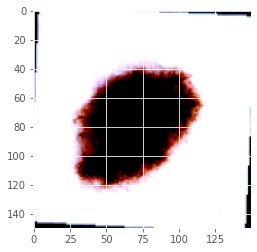

In [ ]:
show_image(*train_set[1030])

Entrenamiento de VGG16 con data augmentation

In [ ]:
epochs = 5
epoch_loss, epoch_acc, val_loss, val_acc, train_time = train(vgg, train_loader, val_loader, optimizer, criterion, epochs)
print("\n --- %s seconds ---", train_time)

Epoch 5/5 - val: 100%|██████████| 118/118 [00:08<00:00, 14.14it/s, acc=0.1356, avg_loss=2.2029]


 --- %s seconds --- 276.6598961353302




---



Los datos...



---



In [ ]:
from torchvision.utils import make_grid

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


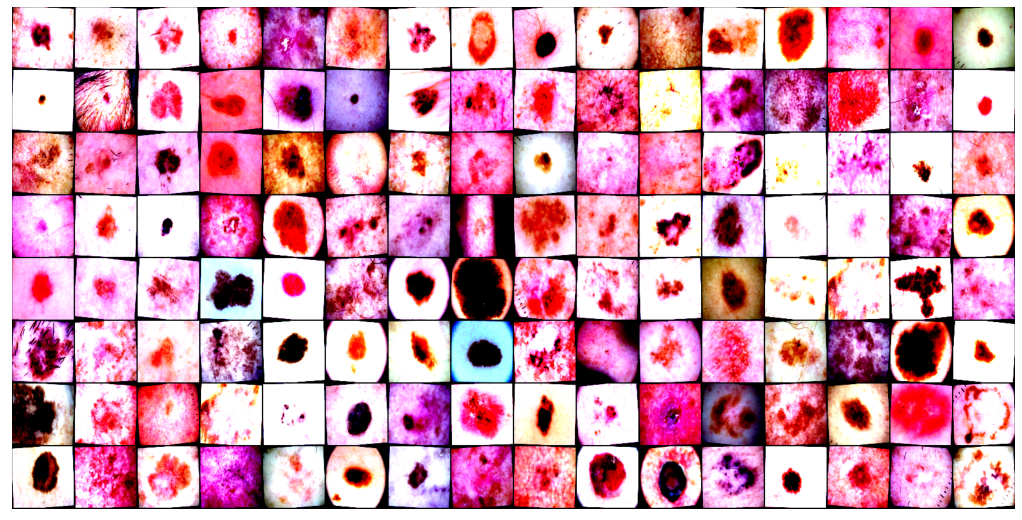

In [ ]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break
